# Predictive Cloud Auto Scaling Based on CPU Load Using Linear Regression

### Assumptions
- This notebook is for the purpose of teaching students about the ideas of auto scaling, the difference between a reactive and proactive approach pinpointing common pitfalls while tuning an auto scaler.
- This notebook assumes that the students do not have a very good understanding of common concepts of cloud auto scaling.

### Delimitations
- This notebook will simulate CPU usage data of 24 hours.
- Simulating current CPU usage in real time while instances scale up or down is out of the scope of this notebook.

### Overview
Cloud based systems have varying load throughout the day. The time of day, the day of the month, the time of year, some or all might play a role in the amount of load being put on the system. Therefore, it is crucial to have the necessary number of servers/virtual machine (VM) instances/Kubernetes pods to ensure service availability and better response times. However, it can hard and tedious to understand what is the appropriate number instances a system should have at a specific time. You also have to consider that having a high number of instances during idle time can drive up cost.

This notebook explores how data driven methods, specifically Linear Regression, can help alleviate this problem using CPU loads and how a system could make decision based on its prediction.

#### Needed Definitions
For us to better understand the contents of this notebook, we first need to understand two important concepts.

**Concept 1: Horizontal Auto Scaling**

A system may consist of multiple different server that have the same exact functionality. This is done to handle higher traffic than that of a single instance can handle. **Changing** the number of instances/servers for this purpose is known as *horizontal scaling* and doing so automatically is known as *horizontal auto scaling*.

**Concept 2: Scale Up/Scale Down**

During a horizontal scaling event, if the number of instances increase, it is called *scaling up*. If the number of instances decrease, it is called *scaling down*.

In this notebook we will simulate a simple environment where:
* CPU utilization varies over time.
* A reactive autoscaling strategy is used to balance load.
* A linear regression model is trained on historical load data (simulated) to forcast future CPU usage.
* The forecast is used to simulate auto scaling using a predictive strategy.

#### Learning Objectives
By the end of this notebook, you will:
* Understand how linear regression can be applied to CPU utilization time series.
* Simulate and compare reactive vs predictive auto scaling strategies.
* Identify common design mistakes in scaling logic and how to debug it.

### Data Simulation

In this section, we are going to simulate the CPU load of a system during a 24 hour window. This will simulate a scenario where the system starts with low load during the morning, slowly rises to high load throughout the day, reaching peak load at 11:00. Then the load will gradually reduce throughout the evening and reach the lowest load at night.

Noise has been added to make the load more realistic. There are also sudden spikes throughout the day which is common for a real world system.

Lets start by importing the necessary python modules.

In [1]:
import numpy as np                  # For numerical operations
import pandas as pd                 # For data visualization
import matplotlib.pyplot as plt     # For plotting

Now we will generate the base load. This will generate a very simple piecewise linear graph, which is not a very good representation of a real load on a production system. Think of this as a rough pencil sketch before the actual details get put into place. If you want to see what this graph looks like, execute the next cell without executing the noise and spike cells and then plot the graph.

In [2]:
# Using a fixed random seed for reproducibility
np.random.seed(43)

minutes = 24 * 60  # 24 hours in minutes
time = np.arange(minutes)

# Initializing CPU load
cpu_load = np.zeros(minutes)

# Defining the boundaries for each linear graph segment
initial = 240           # 00:00 - 04:00 hours
ramp_up_end = 660       # 04:00 - 11:00 hours
peak_end = 900          # 11:00 - 15:00 hours
ramp_down_end = 1260    # 15:00 - 21:00 hours
idle_end = 1440         # 21:00 - 00:00 hours

cpu_load[:initial] = 10 # Idle CPU load is at 10% usage

# Ramp-up: 10% to 80%
cpu_load[initial:ramp_up_end] = np.linspace(10, 80, ramp_up_end - initial)

# Peak usage: 80%
cpu_load[ramp_up_end:peak_end] = 80 # Peak CPU load is at 80% usage

# Ramp-down: 80% to 10%
cpu_load[peak_end:ramp_down_end] = np.linspace(80, 10, ramp_down_end - peak_end)

# Idle: 10%
cpu_load[ramp_down_end:idle_end] = 10

Here, we are adding noise to the base load to make it more realistic. In a real system, there isn't just the one process that uses the resources of the system. There usually is other background processes and CPU load fluctuates. Adding random noise helps to simulate that fact.
> Dev Note: Tested with different types of distributions and found normal distribution to give the best graph.

In [3]:
noise = np.random.normal(0, 5, size=minutes)
cpu_load += noise

Now, in a real system, there are times in a day when there can be a surge of users using the system or maybe theres a scheduled task that runs in the background. During these times, there are random spikes in CPU usage. To simulate this behaviour, we are going to add random spikes to the data at random intervals throughout the day.

In [4]:
spikes = np.zeros(minutes)
for _ in range(np.random.randint(5, 10)):
    start = np.random.randint(0, minutes - 15) # Choosing a random start time
    duration = np.random.randint(3, 15) # How long the spike lasts
    spikes[start:start+duration] += np.random.randint(15, 40)

cpu_load += spikes

We now have the necessary simulation data in `cpu_load`. However, the CPU load is in percentage and therefore there cannot be any load below 0 or above 100. The noise and spike we have added may make some data points exceed this boundary. As a result, we are going to make sure that any data below 0 is set to 0 and any data above 100 is set to 100 using the clip function of numpy.

In [5]:
cpu_load = np.clip(cpu_load, 0, 100)

Now that we have our data, lets visualize it using pandas and matplotlib.

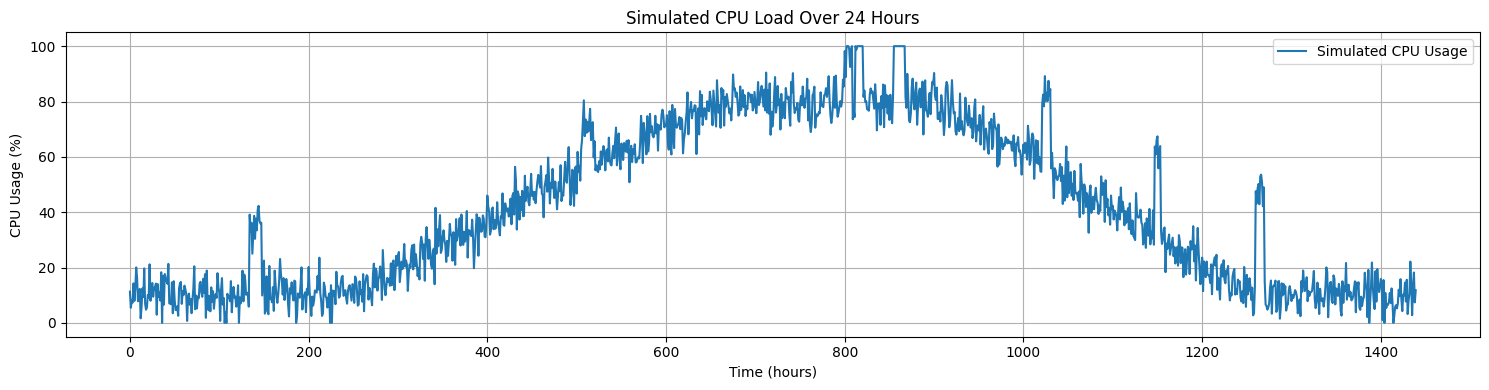

In [6]:
# Create DataFrame
cpu_load_df = pd.DataFrame({
    'minute': time,
    'cpu_usage': cpu_load
})

# Plot the result
plt.figure(figsize=(15, 4))
plt.plot(cpu_load_df['minute'], cpu_load_df['cpu_usage'], label='Simulated CPU Usage')
plt.xlabel('Time (hours)')
plt.ylabel('CPU Usage (%)')
plt.title('Simulated CPU Load Over 24 Hours')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Reactive Auto Scaling

##### What is Reactive Auto Scaling?
Reactive auto scaling is a auto scaling approach where rules are made to scale up or down instances based on a metric, such as CPU load. Threshold values are set and whenever these values are crossed, the auto scaler will either scale up or scale down. It is important to understand that this strategy only uses the data in the current time to make decisions.

Let's starting by writing the reactive auto scaling strategy.

In [7]:
def reactive_autoscale(df, scale_up_threshold = 70, scale_down_threshold = 30, cooldown_period = 1, min_instances = 1):
    instances = [1]     # This will be a list to track instances over time. Start with one instance
    last_scale_time = 0 # Used to track the last scaling time

    for t in range(1, len(df)):
        current_cpu = df['cpu_usage'].iloc[t] # Get the current CPU usage
        current_instances = instances[-1]

        # Check if enough time has passed since the last scaling action
        if (t - last_scale_time) >= cooldown_period:
            if current_cpu > scale_up_threshold:
                # Scale up
                current_instances += 1
                last_scale_time = t
            elif current_cpu < scale_down_threshold and current_instances > min_instances:
                # Scale down
                current_instances -= 1
                last_scale_time = t

        instances.append(current_instances)
    
    return instances

Now, lets define our parameters and execute the code.

In [8]:
scale_up_threshold = 70     # in percentage
scale_down_threshold = 30   # in percentage
cooldown_period = 1         # in minutes

min_instances = 1           # Minimum number of instances

reactive_instance_list = reactive_autoscale(cpu_load_df, scale_up_threshold, scale_down_threshold, cooldown_period, min_instances)

We can now visualize how our reactive scaling strategy worked on the simulated CPU load data.

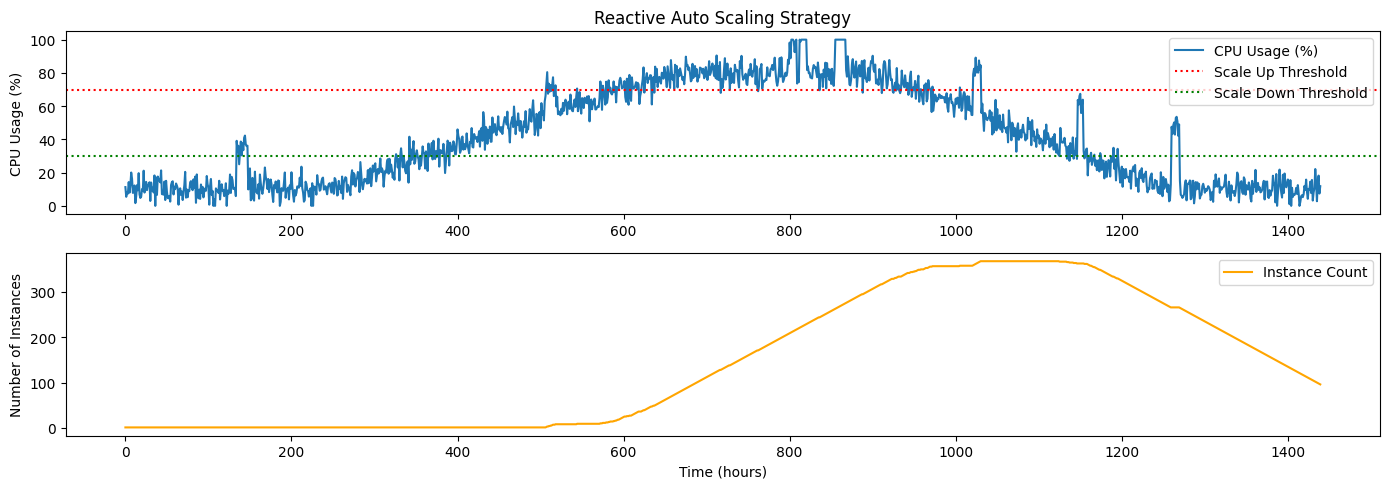

In [ ]:
plt.figure(figsize=(14, 5))

# CPU usage plot
plt.subplot(2, 1, 1)
plt.plot(cpu_load_df['minute'], cpu_load_df['cpu_usage'], label='CPU Usage (%)')
plt.axhline(scale_up_threshold, color='red', linestyle=':', label='Scale Up Threshold')
plt.axhline(scale_down_threshold, color='green', linestyle=':', label='Scale Down Threshold')
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.title("Reactive Auto Scaling Strategy")

# Instance count plot
plt.subplot(2, 1, 2)
plt.plot(cpu_load_df['minute'], reactive_instance_list, label='Instance Count', color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Number of Instances")
plt.legend()

plt.tight_layout()
plt.show()


As you can see, reactive auto scaling is pretty simple to implement. It reacts to the CPU load after it has increased as evident from the right shift of the instance curve. Keep this in mind as we move to explore predictive auto scaling.

### Predictive Auto Scaling

##### What is Predictive Auto Scaling?
Reactive Auto Scaling only reacts **after** a load spike happens. But, what if we could predict an upcoming spike in load  and scale proactively before the spike happens? That is exactly what a predictive auto scaling strategy aims to accomplish.

So, lets dive right in. First, lets import the necessary python package for the prediction. I am choosing a Linear Regression model for this. 

As our load is a piecewise linear graph, a Linear Regression model would be easily able to fit the data.

In [10]:
from sklearn.linear_model import LinearRegression

Now, for our model to fit the data better, we are going to employ a sliding window mechanism. We will feed the model a predefined number of past samples and make it predict future loads, per minute. This way we will have a chance to predict a spike before it happens.



Now, lets write the logic for our predictive auto scaling strategy.

In [11]:
def predictive_autoscale(df, window_size=10, no_of_forecasts=1, scale_up_threshold=70, 
                                    scale_down_threshold=30, cooldown_period=1, min_instances=1):
    current_instances = 1 # No of current instances
    last_scale_time = 0   # Used to track the last scaling time
    predicted_values = [] # List to store predicted CPU loads
    instances = []        # List to store the number of instances over time
    
    model = LinearRegression()
    for t in range(len(df)):
        if t < window_size:
            # Not enough data yet for prediction
            predicted_values.append(0)
            instances.append(current_instances)
            continue

        # Training the model on the last `window_size` data points
        X_train = np.arange(t - window_size, t).reshape(-1, 1)
        y_train = df['cpu_usage'].iloc[t - window_size:t].values
        model.fit(X_train, y_train)

        # Predicting the next `no_of_forecasts` values
        X_future = np.arange(t, t + no_of_forecasts).reshape(-1, 1)
        y_preds = model.predict(X_future)
        max_predicted_load = max(y_preds) # Getting the max predicted load for the forecasted period to predict any upcoming spikes
        predicted_values.append(max_predicted_load)

        # Making decisions based on the predicted load
        if t - last_scale_time >= cooldown_period:
                if max_predicted_load > scale_up_threshold:
                    # Scale up early as we took the max predicted load for the forecasted period
                    current_instances += 1
                    last_scale_time = t
                elif max_predicted_load < scale_down_threshold and current_instances > min_instances:
                    # Scale down
                    current_instances -= 1
                    last_scale_time = t

        instances.append(current_instances)

    df['predicted_cpu'] = predicted_values

    return instances


Now that everything is set up, we can define our parameters and execute the code.

In [12]:
window_size = 60  # Number of past minutes to use as training data for prediction
no_of_forecasts = 120  # Number of future minutes to predict

scale_up_threshold = 70  # in percentage
scale_down_threshold = 30  # in percentage
cooldown_period = 1  # in minutes

min_instances = 1  # Minimum number of instances

predicted_instance_list = predictive_autoscale(cpu_load_df, window_size, no_of_forecasts,
                                                scale_up_threshold, scale_down_threshold, cooldown_period, min_instances)

We have gotten a lot of data now. We have the actual CPU load, the predicted CPU load, and also the instance counts we got from our predictive strategy. Let us now visualize all of these data and see what we can understand from them.

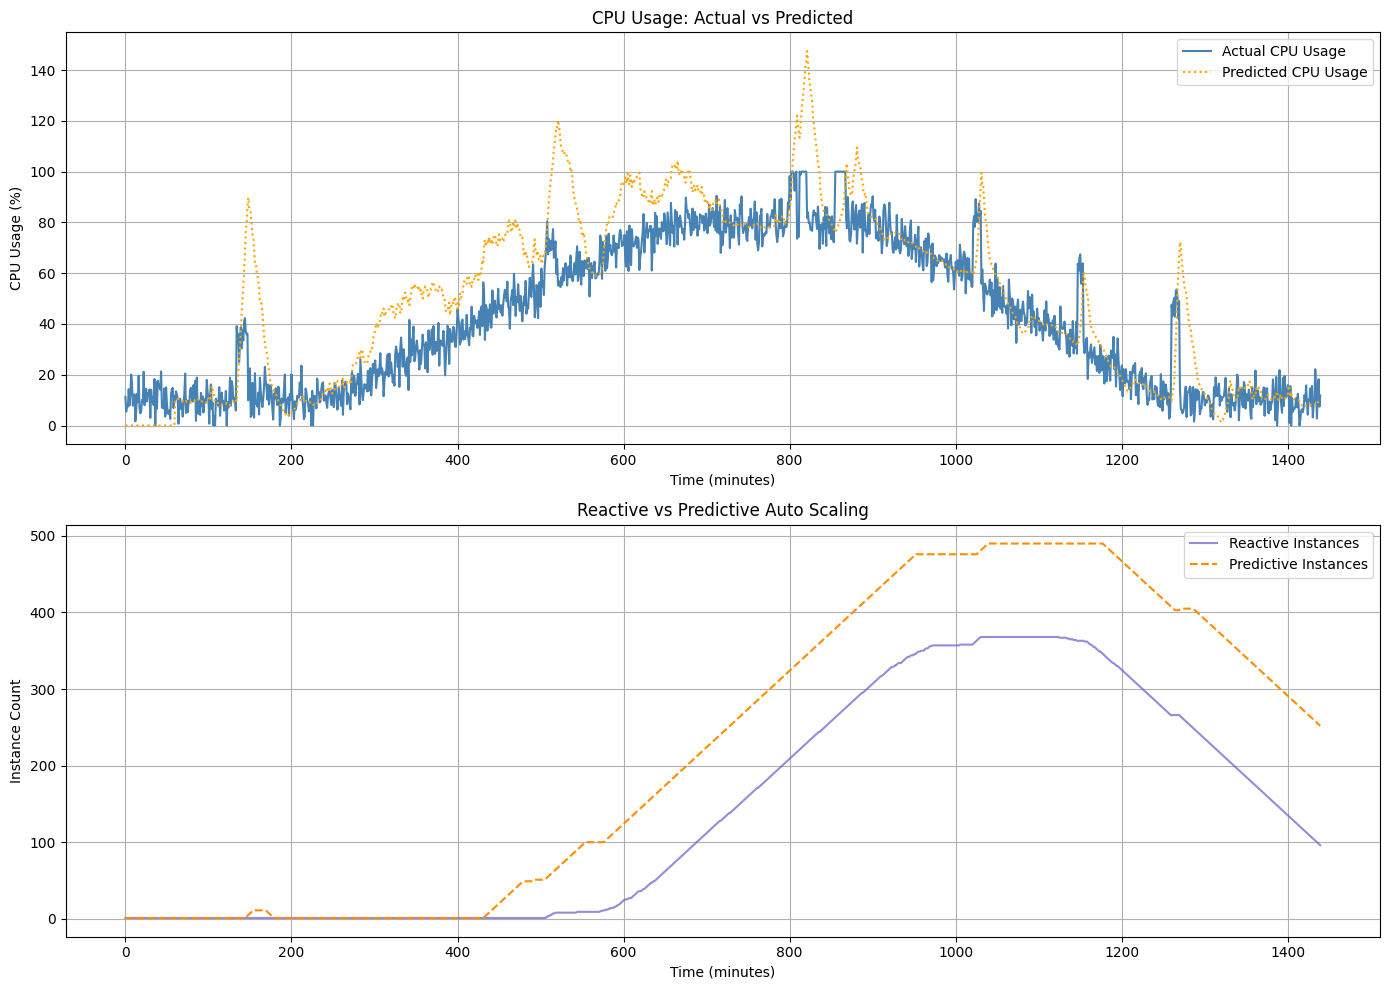

In [13]:
plt.figure(figsize=(14, 10))

# Actual vs Predicted CPU Usage Plot
plt.subplot(2, 1, 1)
plt.plot(cpu_load_df['minute'], cpu_load_df['cpu_usage'], label='Actual CPU Usage', color='steelblue')
plt.plot(cpu_load_df['minute'], cpu_load_df['predicted_cpu'], label='Predicted CPU Usage', linestyle=':', color='orange')
plt.xlabel("Time (minutes)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage: Actual vs Predicted")
plt.legend()
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(cpu_load_df['minute'], reactive_instance_list, label='Reactive Instances', color='slateblue', alpha=0.7)
plt.plot(cpu_load_df['minute'], predicted_instance_list, label='Predictive Instances', color='darkorange', linestyle='--')
plt.xlabel("Time (minutes)")
plt.ylabel("Instance Count")
plt.title("Reactive vs Predictive Auto Scaling")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

As seen from the Instance count curve, Predictive auto scaling starts to scale proactively, before the spikes happens, while reactive auto scaling scales as the spike is happening. Now, we can ask, does the benefit of scaling proactively outweigh the cost of added complexity of the predictive strategy? 

It depends. One concept we have not talked about is how servers/instances take a few minutes of time to become ready to serve traffic. In the case of reactive strategy, where the scale up decision takes place during a spike or increasing load, a lot of traffic cannot be served in the time for the new instances to become ready due to heavy load. As the predictive approach scales before a hitting high load, the scaling instances get enough time to become ready. So when the spike does come, all of the traffic can be served.

### Debug Corner

In this section, we will reflect on some of the intentional (and common) mistakes and oversights in auto scaling strategy design. Understanding these will help you build a more resilient and realistic systems.

#### Mistake: No Maximum Instance Count

**Overview**

If you notice our instance count curves, the number of instances reach up to 400 to 500 instances. In a real world scenario, most systems would not need so many instances to run smoothly. There are two reasons for this.

The first reason is a limitation of this notebook. As a system scales up, the CPU load would go down in real time due to the increased number of instances. However, simulating that is out of the scope of this notebook.

And the second reason is we have not defined a maximum instance count parameter. Even if we simulated the CPU load going down as instance count increased, it would still be a problem if we do not have a maximum bound.

**Why It is a Problem**

Assume we are operating in a cloud environment. During a spike in load an auto scaler can scale up too much, even if that many instances are not needed to handle that spike. In that case, we are incurring cost that is not being benificial to our system. This is a problem encountered in both a reactive and predictive approach.

##### Fix
Introduce a `max_instances` paramater for the auto scaler.

In [14]:
def predictive_autoscale(df, window_size=10, no_of_forecasts=1, scale_up_threshold=70, 
                                    scale_down_threshold=30, cooldown_period=1, min_instances=1, max_instances=10):
    current_instances = 1 # No of current instances
    last_scale_time = 0   # Used to track the last scaling time
    predicted_values = [] # List to store predicted CPU loads
    instances = []        # List to store the number of instances over time
    
    model = LinearRegression()
    for t in range(len(df)):
        if t < window_size:
            # Not enough data yet for prediction
            predicted_values.append(0)
            instances.append(current_instances)
            continue

        # Training the model on the last `window_size` data points
        X_train = np.arange(t - window_size, t).reshape(-1, 1)
        y_train = df['cpu_usage'].iloc[t - window_size:t].values
        model.fit(X_train, y_train)

        # Predicting the next `no_of_forecasts` values
        X_future = np.arange(t, t + no_of_forecasts).reshape(-1, 1)
        y_preds = model.predict(X_future)
        max_predicted_load = max(y_preds) # Getting the max predicted load for the forecasted period to predict any upcoming spikes
        predicted_values.append(max_predicted_load)

        # Making decisions based on the predicted load
        if t - last_scale_time >= cooldown_period:
                
                if max_predicted_load > scale_up_threshold and current_instances < max_instances:
                    # Scale up early as we took the max predicted load for the forecasted period
                    current_instances += 1
                    last_scale_time = t
                elif max_predicted_load < scale_down_threshold and current_instances > min_instances:
                    # Scale down
                    current_instances -= 1
                    last_scale_time = t

        instances.append(current_instances)

    df['predicted_cpu'] = predicted_values

    return instances

In [15]:
window_size = 30  # Number of past minutes to use as training data for prediction
no_of_forecasts = 60  # Number of future minutes to predict

scale_up_threshold = 70  # in percentage
scale_down_threshold = 30  # in percentage
cooldown_period = 1  # in minutes

min_instances = 1  # Minimum number of instances
max_instances = 10  # Maximum number of instances

predicted_instance_list = predictive_autoscale(cpu_load_df, window_size, no_of_forecasts, scale_up_threshold, 
                                                scale_down_threshold, cooldown_period, min_instances, max_instances)

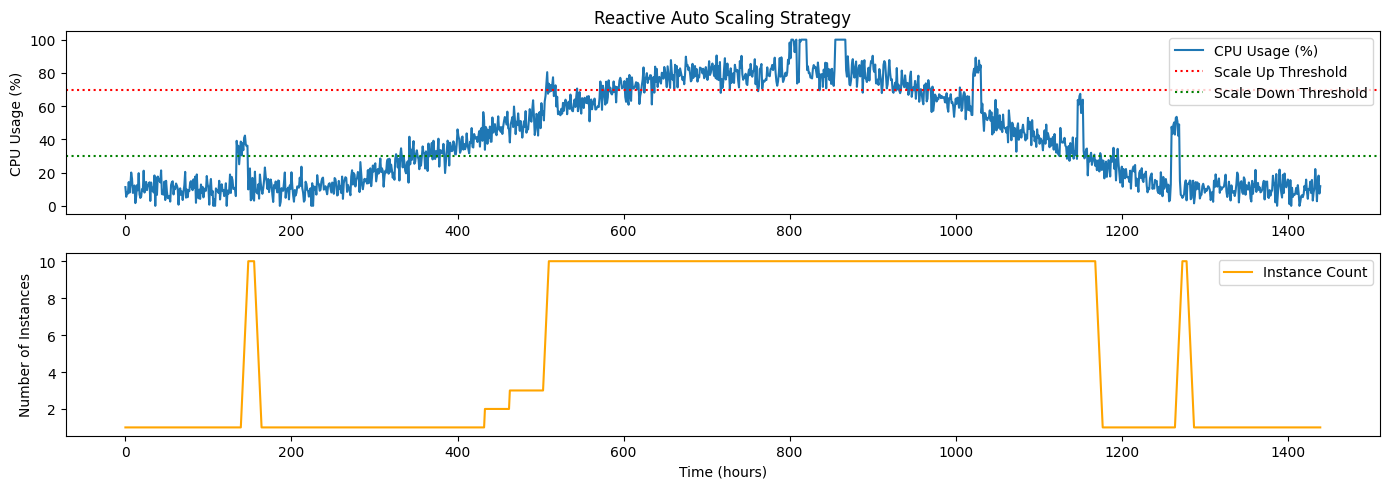

In [16]:
plt.figure(figsize=(14, 5))

# CPU usage plot
plt.subplot(2, 1, 1)
plt.plot(cpu_load_df['minute'], cpu_load_df['cpu_usage'], label='CPU Usage (%)')
plt.axhline(scale_up_threshold, color='red', linestyle=':', label='Scale Up Threshold')
plt.axhline(scale_down_threshold, color='green', linestyle=':', label='Scale Down Threshold')
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.title("Reactive Auto Scaling Strategy")

# Instance count plot
plt.subplot(2, 1, 2)
plt.plot(cpu_load_df['minute'], predicted_instance_list, label='Instance Count', color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Number of Instances")
plt.legend()

plt.tight_layout()
plt.show()

#### Mistake: Very low Cooldown Period
**Overview**

If you notice, we have set the cooldown period to 1 min. Which means the auto scaler is allowed to scale up or down within every minute. However, traffic in a real world system is unpredictable in a smaller context. So, what happens if one minute the load is very high, the next minute the load drops drastically and the next minute the load drastically increases again?

**Why It is a Problem**

- It may lead to a concept called *thrashing*. It is when scale up and scale down happens in rapid succession in a short period of time. This may cause an unwanted scale down of instances when we need more instances. 
- It does not allow the CPU load to normalize. For example, when a scale up happens, CPU load should go down due to the increased instance count. But it is not instantaneous. Therefore, the auto scaler will try to scale up even if the current number of instances are sufficient to handle the load. Which then leads to a very low load, which causes a scale down event and the system ends up thrashing.

##### Fix
Increase the cooldown period parameter to 5 mins.

In [17]:
window_size = 30  # Number of past minutes to use as training data for prediction
no_of_forecasts = 60  # Number of future minutes to predict

scale_up_threshold = 70  # in percentage
scale_down_threshold = 30  # in percentage
cooldown_period = 10  # in minutes

min_instances = 1  # Minimum number of instances
max_instances = 10  # Maximum number of instances

predicted_instance_list = predictive_autoscale(cpu_load_df, window_size, no_of_forecasts, scale_up_threshold, 
                                                scale_down_threshold, cooldown_period, min_instances, max_instances)

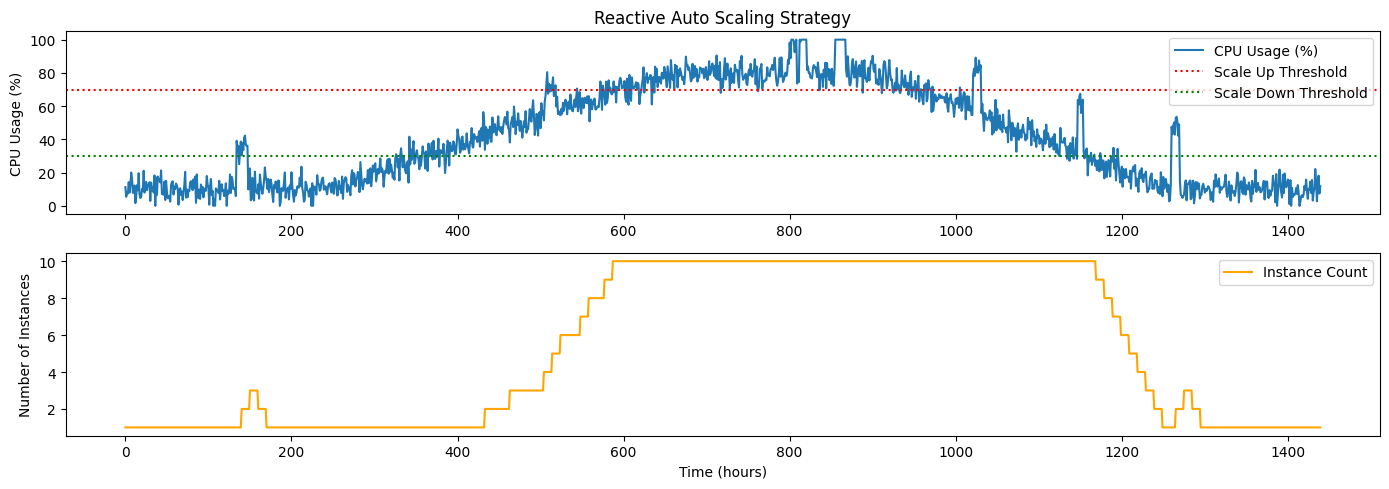

In [18]:
plt.figure(figsize=(14, 5))

# CPU usage plot
plt.subplot(2, 1, 1)
plt.plot(cpu_load_df['minute'], cpu_load_df['cpu_usage'], label='CPU Usage (%)')
plt.axhline(scale_up_threshold, color='red', linestyle=':', label='Scale Up Threshold')
plt.axhline(scale_down_threshold, color='green', linestyle=':', label='Scale Down Threshold')
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.title("Reactive Auto Scaling Strategy")

# Instance count plot
plt.subplot(2, 1, 2)
plt.plot(cpu_load_df['minute'], predicted_instance_list, label='Instance Count', color='orange')
plt.xlabel("Time (hours)")
plt.ylabel("Number of Instances")
plt.legend()

plt.tight_layout()
plt.show()

#### Misconception: Using only a sliding window mechanism of few minutes
**Overview**

We have used only a sliding window mechanism to view the past few minutes of data to train the linear regression model and then used it to predict future loads. This may give us a short term view of the data trend and quickly adapt to sudden spikes in data. However, another important feature of an auto scaler other than adapting to sudden spikes is being able to understand daily trends and schedule accordingly. This approach lacks in understanding a long term pattern that only emerges when looking at more past data than just a few minutes.

**Why It is a Problem**

- Cannot use daily trends for better scheduling.
- Cannot anticipate seasonal or holiday trends.

**A Improved Solution**

A better way to deal with this would be to first train the model with multiple past days, if not months, and then incorporate a sliding window mechanism on top of that. This would allow the model to not only adapt quickly to recent changes in load, but also use its insights to schedule better on a day to day basis.

### Conclusion
In this notebook, we explored the application of linear regression as a data-driven method to enhance auto scaling strategies in cloud environments. We began by simulating realistic CPU load data using a piecewise linear pattern with added noise. This enabled us to evaluate two distinct scaling strategies:
- Reactive Auto Scaling – where decisions are made solely based on current CPU load.
- Predictive Auto Scaling – where linear regression forecasts future CPU load over a short period of time, and scaling decisions are made proactively.

We implemented a sliding window approach that continuously updates the model with recent data to predict short-term CPU trends. 

We also introduced a predictive auto scaling policy by:
- Using a Linear Regression model to forecast future CPU loads.
- Using the forecast to proactively scale up and down instances.

Finally, we reflected on common mistakes and misconceptions in the Debug Corner, including:
- The risks of not putting an upper limit to the number of instances.
- The instability caused by a low cooldown period.
- The value of incorporating long-term historical patterns into prediction models.

**Key Takeaways**
- Data-driven methods, even simple ones like linear regression, can significantly improve cloud resource management when paired with thoughtful policy design.
- Proactive auto scaling can reduce latency and improve system availability during load surges.
- Effective scaling policies must strike a balance between performance, cost, and system stability.
- Simulations like this one can guide real-world infrastructure decisions and serve as valuable educational tools.